In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# 1. 加载和预处理数据，并划分训练集、验证集和测试集
def load_data():
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
    test_images = test_images.reshape(test_images.shape[0], -1) / 255.0
    
    # 划分训练集、验证集和测试集
    num_train = int(0.8 * train_images.shape[0])
    num_val = int(0.2 * train_images.shape[0])
    #num_test = train_images.shape[0] - num_train - num_val

    X_train = train_images[:num_train]
    y_train = train_labels[:num_train]
    X_val = train_images[num_train:num_train + num_val]
    y_val = train_labels[num_train:num_train + num_val]
    X_test = test_images
    y_test = test_labels
    # X_test = train_images[num_train + num_val:]
    # y_test = train_labels[num_train + num_val:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# 2. 定义三层神经网络模型类
class NeuralNetwork2:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation='relu'):
        self.weights = {
            'W1': np.random.randn(input_size, hidden_size1) * 0.01,
            'W2': np.random.randn(hidden_size1, hidden_size2) * 0.01,
            'W3': np.random.randn(hidden_size2, output_size) * 0.01
        }
        self.biases = {
            'b1': np.zeros((1, hidden_size1)),
            'b2': np.zeros((1, hidden_size2)),
            'b3': np.zeros((1, output_size))
        }
        self.activation = activation

    def activate(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Unsupported activation function")
    
    def activate_derivative(self, x):
        if self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'sigmoid':
            sig = self.activate(x)
            return sig * (1 - sig)
        elif self.activation == 'tanh':
            return 1 - np.tanh(x)**2
        else:
            raise ValueError("Unsupported activation function")

    def forward(self, X):
        self.Z1 = X.dot(self.weights['W1']) + self.biases['b1']
        self.A1 = self.activate(self.Z1)
        self.Z2 = self.A1.dot(self.weights['W2']) + self.biases['b2']
        self.A2 = self.activate(self.Z2)
        self.Z3 = self.A2.dot(self.weights['W3']) + self.biases['b3']
        self.A3 = self.softmax(self.Z3)
        return self.A3

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred, lambda_):
        m = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(m), y_true])
        l2_penalty = lambda_ * (np.sum(np.square(self.weights['W1'])) + np.sum(np.square(self.weights['W2'])) + np.sum(np.square(self.weights['W3'])))
        loss = np.sum(log_likelihood) / m + l2_penalty
        return loss

    def backward(self, X, y_true, lambda_):
        m = X.shape[0]
        delta3 = self.A3
        delta3[range(m), y_true] -= 1
        dW3 = self.A2.T.dot(delta3) / m + lambda_ * self.weights['W3']
        db3 = np.sum(delta3, axis=0, keepdims=True) / m
        delta2 = delta3.dot(self.weights['W3'].T) * self.activate_derivative(self.Z2)
        dW2 = self.A1.T.dot(delta2) / m + lambda_ * self.weights['W2']
        db2 = np.sum(delta2, axis=0, keepdims=True) / m
        delta1 = delta2.dot(self.weights['W2'].T) * self.activate_derivative(self.Z1)
        dW1 = X.T.dot(delta1) / m + lambda_ * self.weights['W1']
        db1 = np.sum(delta1, axis=0, keepdims=True) / m
        return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dW3': dW3, 'db3': db3}

    def update_params(self, grads, learning_rate):
        self.weights['W1'] -= learning_rate * grads['dW1']
        self.weights['W2'] -= learning_rate * grads['dW2']
        self.weights['W3'] -= learning_rate * grads['dW3']
        self.biases['b1'] -= learning_rate * grads['db1']
        self.biases['b2'] -= learning_rate * grads['db2']
        self.biases['b3'] -= learning_rate * grads['db3']



# 3. 训练模型
def train_model(X_train, y_train, X_val, y_val, epochs=50, learning_rate=0.1, batch_size=64, hidden_size1=128,hidden_size2=32, activation='relu', lambda_=0.001):
    # history = {'train_loss': [], 'val_accuracy': []}
    # # 初始化记录历史的字典
    history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
    }

    model = NeuralNetwork2(784, hidden_size1,hidden_size2, 10, activation)
    best_acc = 0.0
    best_weights = None
    for epoch in range(epochs):
        # SGD优化器
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        batch_losses = []
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            output = model.forward(X_batch)
            loss = model.compute_loss(y_batch, output, lambda_)
            grads = model.backward(X_batch, y_batch, lambda_)
            model.update_params(grads, learning_rate)
    
            batch_losses.append(loss)
        # 记录训练损失
        train_loss = np.mean(batch_losses)
        history['train_loss'].append(train_loss)
        
        # 计算和记录训练准确率
        train_predictions = model.forward(X_train)
        train_accuracy = np.mean(np.argmax(train_predictions, axis=1) == y_train)
        history['train_accuracy'].append(train_accuracy)
        
        # 计算和记录验证准确率和损失
        val_predictions = model.forward(X_val)
        val_loss = model.compute_loss(y_val, val_predictions, lambda_)
        val_accuracy = np.mean(np.argmax(val_predictions, axis=1) == y_val)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_weights = {k: v.copy() for k, v in model.weights.items()}
        # print(f'Epoch {epoch + 1}, Loss: {loss}, Validation Accuracy: {val_accuracy}')
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")
        learning_rate *= 0.95  # Learning rate decay

    # Load best model weights
    model.weights = best_weights
    return history, model



# 5. 保存模型权重到本地
def save_model_weights(model, filename='model_weights.npz'):
    np.savez(filename, W1=model.weights['W1'], W2=model.weights['W2'], W3=model.weights['W3'], b1=model.biases['b1'], b2=model.biases['b2'], b3=model.biases['b3'])
    print("Model weights saved to", filename)

# 6. 测试模型
def test_model(model, X_test, y_test):
    predictions = model.forward(X_test)
    accuracy = np.mean(np.argmax(predictions, axis=1) == y_test)
    print(f"Test Set Accuracy: {accuracy}")
    return accuracy

# 7. 超参数调优
def hyperparameter_search(X_train, y_train, X_val, y_val):
    learning_rates = [0.1, 0.2]
    hidden_sizes = [(128,128),(256,256)]
    regularization_strengths = [0.001, 0.005, 0.01]
    # learning_rates = [0.1]
    # hidden_sizes = [64]
    # regularization_strengths = [0.001]

    best_val = -1
    best_params = {}

    results = []
    for lr in learning_rates:
        for hs in hidden_sizes:
            hs1 = hs[0]
            hs2 = hs[1]
            for reg in regularization_strengths:
                print(f"Training with lr={lr}, hidden_size1={hs1}, hidden_size2={hs2}, reg={reg}")
                history, model = train_model(X_train, y_train, X_val, y_val, epochs=1,
                                            learning_rate=lr, hidden_size1=hs1,hidden_size2=hs2, lambda_=reg)
                val_accuracy = max(history['val_accuracy'])
                results.append((lr, hs1, hs2, reg, val_accuracy))
                if val_accuracy > best_val:
                    best_val = val_accuracy
                    best_params = {'lr': lr, 'hidden_size1': hs1,'hidden_size2':hs2, 'reg': reg}
                print(f"Validation accuracy: {val_accuracy}")

    print("Best validation accuracy:", best_val)
    print("Best hyperparameters:", best_params)
    return best_params

# 主程序
if __name__ == '__main__':
    X_train, y_train, X_val, y_val, X_test, y_test = load_data()
    best_params = hyperparameter_search(X_train, y_train, X_val, y_val)

    history, model = train_model(X_train, y_train, X_val, y_val, epochs=10,
                                 learning_rate=best_params['lr'],
                                 hidden_size1=best_params['hidden_size1'],
                                 hidden_size2=best_params['hidden_size2'],
                                 lambda_=best_params['reg'],
                                 activation='relu')
    save_model_weights(model)
    test_accuracy = test_model(model, X_test, y_test)
    print(test_accuracy)

Training with lr=0.1, hidden_size1=128, hidden_size2=128, reg=0.001
Epoch 1: Train Loss = 1.2528, Train Accuracy = 0.7638, Val Loss = 0.7024, Val Accuracy = 0.7678
Validation accuracy: 0.7678333333333334
Training with lr=0.1, hidden_size1=128, hidden_size2=128, reg=0.005
Epoch 1: Train Loss = 1.3886, Train Accuracy = 0.7617, Val Loss = 0.8739, Val Accuracy = 0.7657
Validation accuracy: 0.7656666666666667
Training with lr=0.1, hidden_size1=128, hidden_size2=128, reg=0.01
Epoch 1: Train Loss = 1.5314, Train Accuracy = 0.7466, Val Loss = 1.0171, Val Accuracy = 0.7518
Validation accuracy: 0.7518333333333334
Training with lr=0.1, hidden_size1=256, hidden_size2=256, reg=0.001
Epoch 1: Train Loss = 1.1061, Train Accuracy = 0.7542, Val Loss = 0.7244, Val Accuracy = 0.7524
Validation accuracy: 0.7524166666666666
Training with lr=0.1, hidden_size1=256, hidden_size2=256, reg=0.005
Epoch 1: Train Loss = 1.3230, Train Accuracy = 0.7643, Val Loss = 0.8847, Val Accuracy = 0.7650
Validation accuracy: 

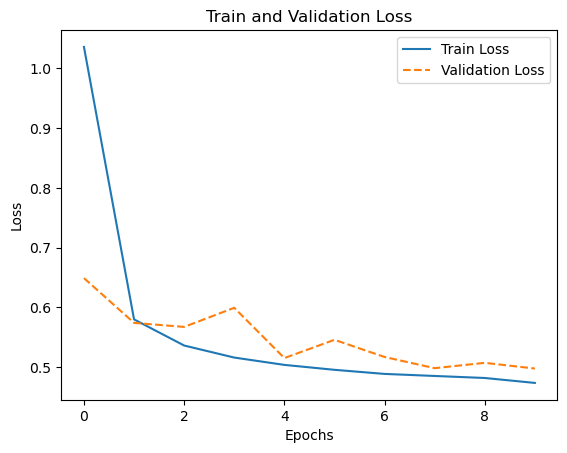

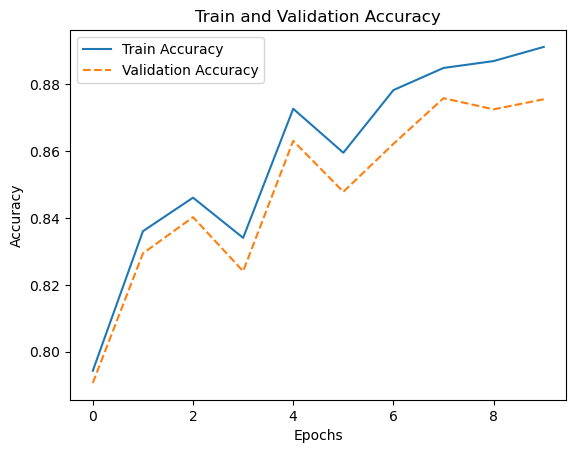

In [8]:
def plot_loss_acc(history):

    # 绘制训练和验证损失
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')
    plt.show()

    # 绘制训练和验证准确率
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Train and Validation Accuracy')
    plt.show()
plot_loss_acc(history)

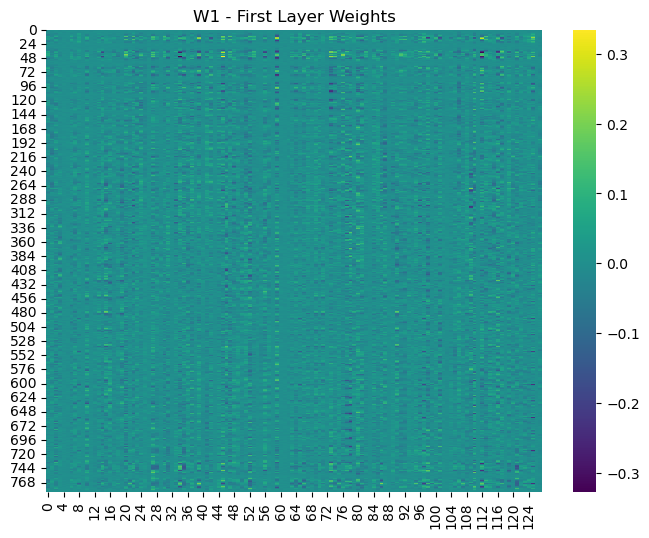

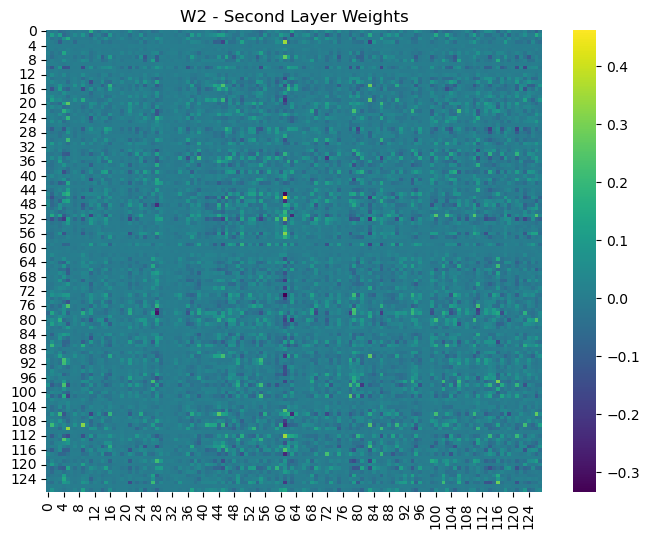

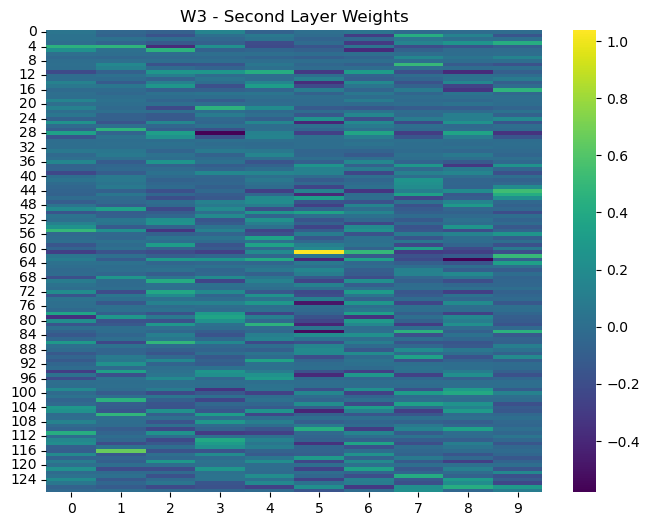

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 读取NPZ文件
data = np.load("model_weights.npz")

# 获取第一层和第二层的权重
W1 = data["W1"]
W2 = data["W2"]
W3 = data["W3"]
# 绘制第一层的权重热图
plt.figure(figsize=(8, 6))
sns.heatmap(W1, annot=False, cmap='viridis', cbar=True)  # 使用颜色条增加直观性
plt.title("W1 - First Layer Weights")
plt.show()  # 展示第一层权重

# 绘制第二层的权重热图
plt.figure(figsize=(8, 6))
sns.heatmap(W2, annot=False, cmap='viridis', cbar=True)  # 展示权重和数值
plt.title("W2 - Second Layer Weights")
plt.show()  # 展示第二层权重

# 绘制第三层的权重热图
plt.figure(figsize=(8, 6))
sns.heatmap(W3, annot=False, cmap='viridis', cbar=True)  # 展示权重和数值
plt.title("W3 - Second Layer Weights")
plt.show()  # 展示第三层权重
